Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=229143360009c1759386c7dcea78350d95bfa8185ea247d56036879a130e421e
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 28.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 10.8 MB/s 
     |████████████████████████████████| 7.6 MB 60.4 MB/s 
     |████████████████████████████████| 163 kB 45.2 MB/s 
[14208, 13365, 10759, 897, 1284, 3303, 6314, 13365, 4367, 

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-28 07:22:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-28 07:22:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-28 07:22:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10928 words (7728 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 651, 100)          1865700   
                                                                 
 bidirectional (Bidirectiona  (None, 651, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 651, 5)           1005      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 651, 5)            25        
                                                                 
Total params: 2,027,530
Trainable params: 2,027,530
Non-trainable pa

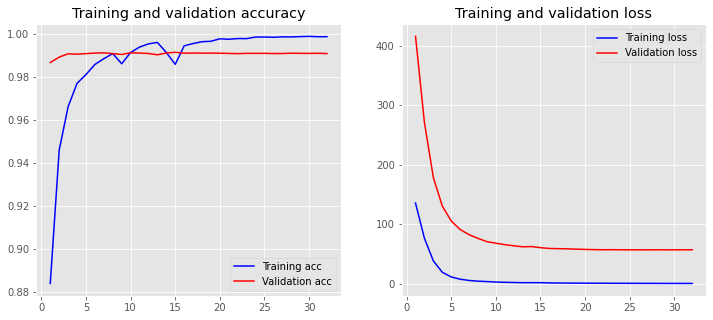

32/32 [==============================] - 10s 215ms/step
F1-score: 67.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7752808988764045,0.6571428571428571,0.711340206185567,5040.0
Disease,0.6183574879227053,0.6343771119621536,0.6262648726787501,4439.0
micro avg,0.6943122592340811,0.6464816963814748,0.669543840480743,9479.0
macro avg,0.6968191933995549,0.6457599845525054,0.6688025394321586,9479.0
weighted avg,0.701793925437912,0.6464816963814748,0.6714995684139919,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10946 words (7730 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 651, 100)          1867700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,029,530
Trainable params: 2,029,530
Non-trainable 

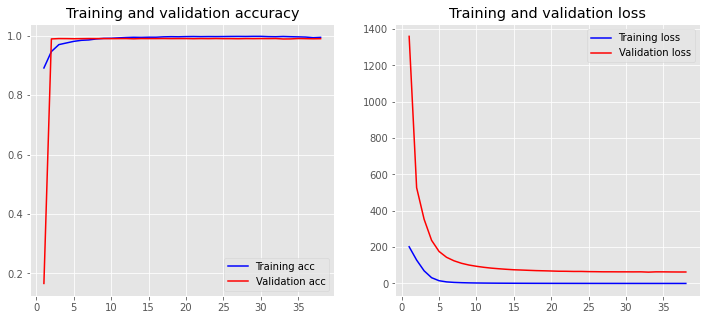

32/32 [==============================] - 10s 208ms/step
F1-score: 65.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6141965678627145,0.7811507936507937,0.6876855895196506,5040.0
Disease,0.5947725869520477,0.6510475332282045,0.6216390621639062,4439.0
micro avg,0.6058212796166474,0.7202236522839962,0.6580875265085792,9479.0
macro avg,0.604484577407381,0.7160991634394991,0.6546623258417784,9479.0
weighted avg,0.6051003497740501,0.7202236522839962,0.656756110151347,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10933 words (7711 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 651, 100)          1864500   
                                                                 
 bidirectional_2 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,026,330
Trainable params: 2,026,330
Non-trainable 

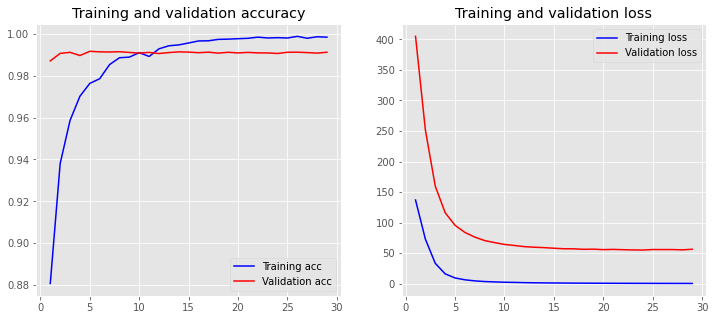

32/32 [==============================] - 10s 213ms/step
F1-score: 67.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7245642480745845,0.7093253968253969,0.716863845999599,5040.0
Disease,0.6101694915254238,0.6569047082676278,0.6326752006942938,4439.0
micro avg,0.6682796252445177,0.6847768751978057,0.6764276781992498,9479.0
macro avg,0.6673668698000041,0.6831150525465124,0.6747695233469464,9479.0
weighted avg,0.6709933730538308,0.6847768751978057,0.6774384428441764,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10935 words (7719 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 651, 100)          1865500   
                                                                 
 bidirectional_3 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,027,330
Trainable params: 2,027,330
Non-trainable 

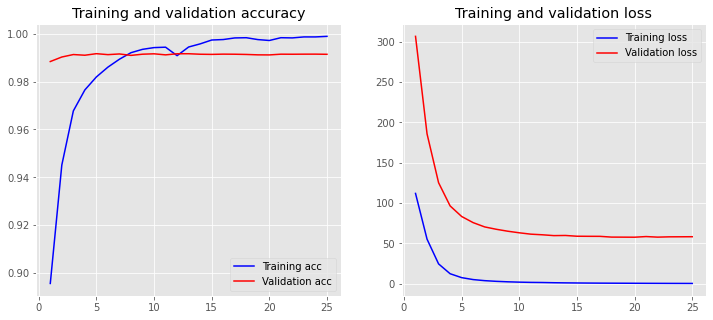

32/32 [==============================] - 10s 218ms/step
F1-score: 68.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.793949117579647,0.6873015873015873,0.7367861320855046,5040.0
Disease,0.6154485049833887,0.6677179544942554,0.6405186385737439,4439.0
micro avg,0.7002941496895086,0.678130604494145,0.689034194447422,9479.0
macro avg,0.7046988112815178,0.6775097708979214,0.6886523853296243,9479.0
weighted avg,0.710357576350109,0.678130604494145,0.691704224321109,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10922 words (7734 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 651, 100)          1865700   
                                                                 
 bidirectional_4 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,027,530
Trainable params: 2,027,530
Non-trainable 

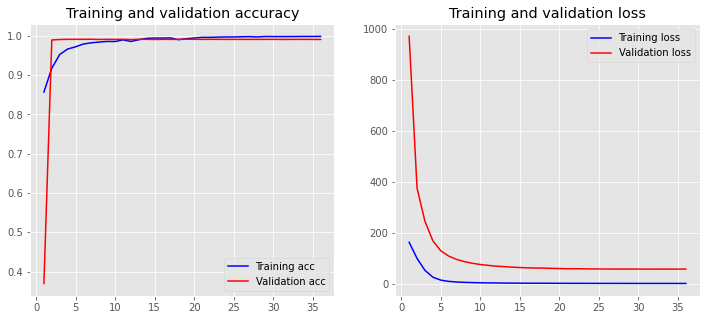

32/32 [==============================] - 10s 215ms/step
F1-score: 66.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7100840336134454,0.6706349206349206,0.6897959183673469,5040.0
Disease,0.6225870867539384,0.6321243523316062,0.6273194723898948,4439.0
micro avg,0.6675299449660084,0.6526004852832578,0.659980795903126,9479.0
macro avg,0.6663355601836919,0.6513796364832634,0.6585576953786209,9479.0
weighted avg,0.6691093583197064,0.6526004852832578,0.6605383021953973,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10928 words (7737 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 651, 100)          1866600   
                                                                 
 bidirectional_5 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,028,430
Trainable params: 2,028,430
Non-trainable 

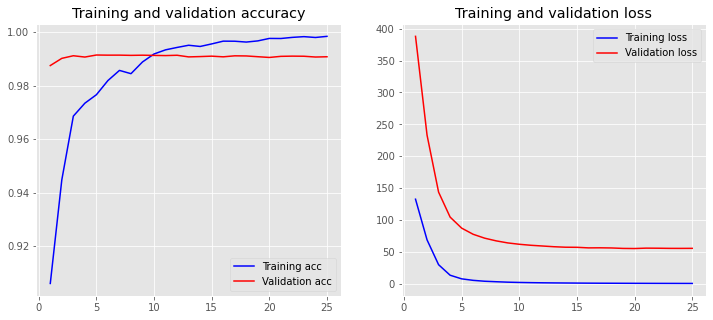

32/32 [==============================] - 10s 214ms/step
F1-score: 67.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7154861944777912,0.7095238095238096,0.7124925283921101,5040.0
Disease,0.6130202774813234,0.6469925658932192,0.6295484436650591,4439.0
micro avg,0.6659093256222245,0.6802405317016563,0.6729986431478969,9479.0
macro avg,0.6642532359795572,0.6782581877085143,0.6710204860285847,9479.0
weighted avg,0.6675015752619118,0.6802405317016563,0.6736499508941273,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10944 words (7723 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 651, 100)          1866800   
                                                                 
 bidirectional_6 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,028,630
Trainable params: 2,028,630
Non-trainable 

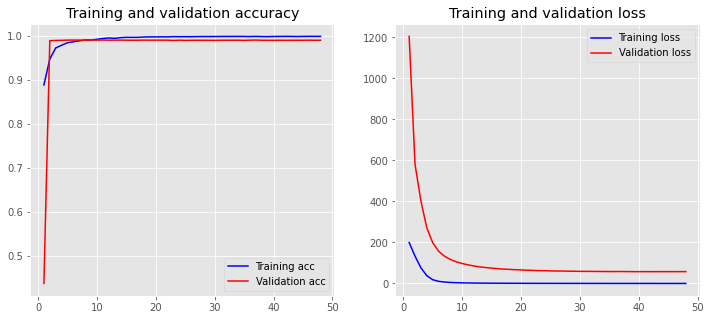

32/32 [==============================] - 10s 215ms/step
F1-score: 67.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7717738258093936,0.6716269841269841,0.7182261828983663,5040.0
Disease,0.6131749460043197,0.6395584591124127,0.6260888741867903,4439.0
micro avg,0.6903283052351376,0.6566093469775293,0.6730467693971344,9479.0
macro avg,0.6924743859068566,0.6555927216196984,0.6721575285425783,9479.0
weighted avg,0.6975022330828694,0.6566093469775293,0.6750784338351017,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10907 words (7698 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 651, 100)          1860600   
                                                                 
 bidirectional_7 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,022,430
Trainable params: 2,022,430
Non-trainable 

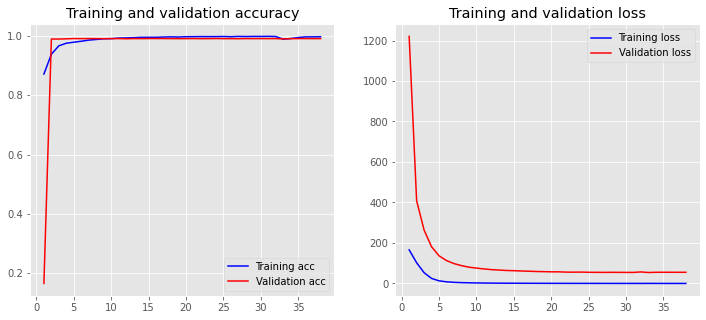

32/32 [==============================] - 10s 209ms/step
F1-score: 66.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7489539748953975,0.6748015873015873,0.7099467696482623,5040.0
Disease,0.5759872357399282,0.6505969813020951,0.6110229556754468,4439.0
micro avg,0.6581894296180011,0.6634666104019411,0.6608174845014185,9479.0
macro avg,0.6624706053176628,0.6626992843018412,0.6604848626618546,9479.0
weighted avg,0.6679539374324659,0.6634666104019411,0.6636209114115994,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10931 words (7732 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 651, 100)          1866400   
                                                                 
 bidirectional_8 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,028,230
Trainable params: 2,028,230
Non-trainable 

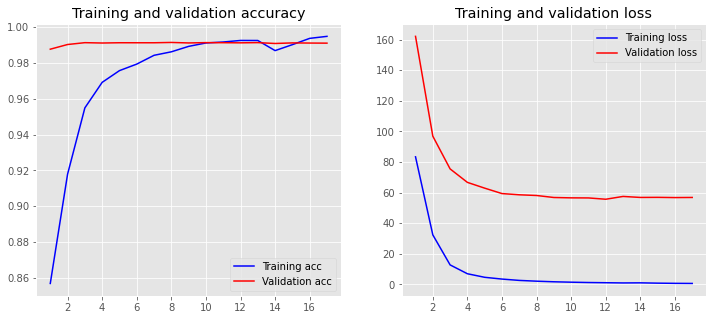

32/32 [==============================] - 10s 220ms/step
F1-score: 69.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7194931773879142,0.7323412698412698,0.7258603736479843,5040.0
Disease,0.654650645304851,0.6627618833070511,0.6586812940781372,4439.0
micro avg,0.689214463840399,0.6997573583711362,0.6944458985499661,9479.0
macro avg,0.6870719113463826,0.6975515765741604,0.6922708338630608,9479.0
weighted avg,0.6891275270116385,0.6997573583711362,0.6944005219536546,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10925 words (7719 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 651, 100)          1864500   
                                                                 
 bidirectional_9 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,026,330
Trainable params: 2,026,330
Non-trainable 

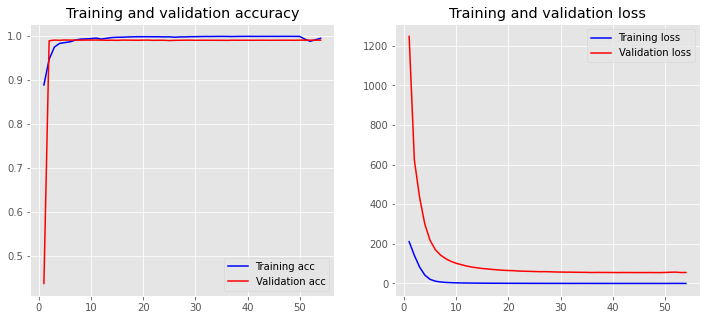

32/32 [==============================] - 10s 213ms/step
F1-score: 68.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7344364012409514,0.7045634920634921,0.7191898734177216,5040.0
Disease,0.6453058480842483,0.6487947735976571,0.6470456077286003,4439.0
micro avg,0.6916541191654119,0.6784470935752717,0.6849869521222772,9479.0
macro avg,0.6898711246625999,0.6766791328305746,0.683117740573161,9479.0
weighted avg,0.692696710823966,0.6784470935752717,0.6854048332875381,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10965 words (7781 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 651, 100)          1874700   
                                                                 
 bidirectional_10 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,036,530
Trainable params: 2,036,530
Non-trainable

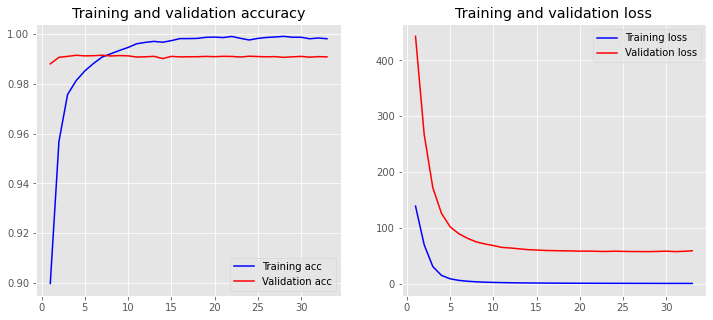

32/32 [==============================] - 10s 215ms/step
F1-score: 66.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7100651996740016,0.691468253968254,0.7006433453960595,5040.0
Disease,0.613459516298633,0.6571299842306826,0.6345442680008703,4439.0
micro avg,0.6625271654765601,0.6753876991243802,0.6688956221920385,9479.0
macro avg,0.6617623579863173,0.6742991190994683,0.6675938066984649,9479.0
weighted avg,0.6648249181566199,0.6753876991243802,0.6696892569313222,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10989 words (7773 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 651, 100)          1876300   
                                                                 
 bidirectional_11 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,038,130
Trainable params: 2,038,130
Non-trainable

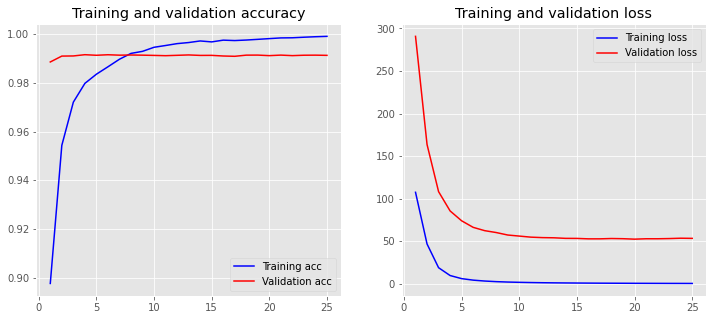

32/32 [==============================] - 10s 214ms/step
F1-score: 68.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7186282151208107,0.7317460317460317,0.7251278018088871,5040.0
Disease,0.65311279577303,0.6404595629646317,0.6467242948134668,4439.0
micro avg,0.6885608856088561,0.6889967296128283,0.6887787386627294,9479.0
macro avg,0.6858705054469203,0.6861027973553318,0.685926048311177,9479.0
weighted avg,0.6879474527529662,0.6889967296128283,0.6884115693421005,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10984 words (7763 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 651, 100)          1874800   
                                                                 
 bidirectional_12 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,036,630
Trainable params: 2,036,630
Non-trainable

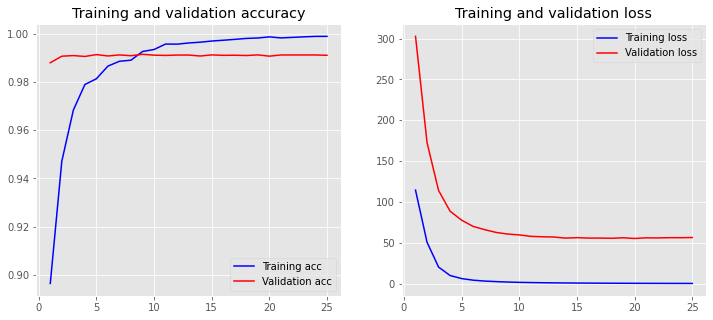

32/32 [==============================] - 10s 213ms/step
F1-score: 67.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7033765213977228,0.7109126984126984,0.7071245312808369,5040.0
Disease,0.6287161418189826,0.6431628745212886,0.6358574610244989,4439.0
micro avg,0.6681888946549039,0.6791855680979006,0.6736423563879879,9479.0
macro avg,0.6660463316083527,0.6770377864669935,0.6714909961526678,9479.0
weighted avg,0.6684131893004522,0.6791855680979006,0.6737502803189332,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10973 words (7767 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 651, 100)          1874100   
                                                                 
 bidirectional_13 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,035,930
Trainable params: 2,035,930
Non-trainable

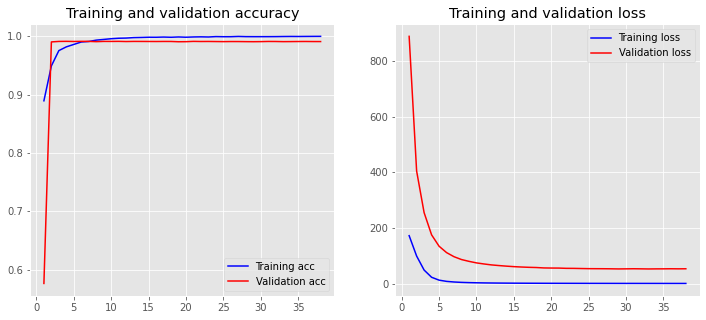

32/32 [==============================] - 10s 212ms/step
F1-score: 67.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7550387596899225,0.6763888888888889,0.7135531135531136,5040.0
Disease,0.6089935760171307,0.6406848389276865,0.6244373696344275,4439.0
micro avg,0.6807838867719107,0.6596687414284207,0.6700600085726532,9479.0
macro avg,0.6820161678535266,0.6585368639082877,0.6689952415937706,9479.0
weighted avg,0.6866460420695487,0.6596687414284207,0.671820358277763,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10995 words (7763 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 651, 100)          1875900   
                                                                 
 bidirectional_14 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,037,730
Trainable params: 2,037,730
Non-trainable

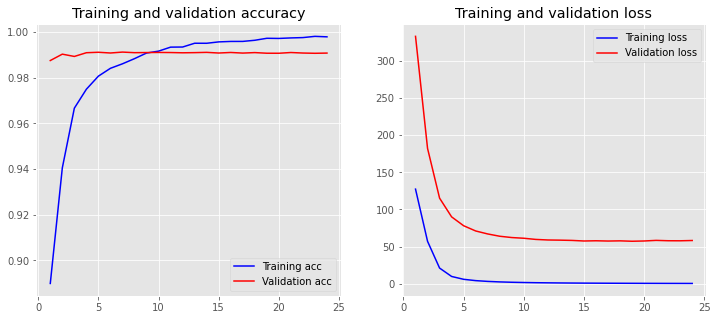

32/32 [==============================] - 10s 217ms/step
F1-score: 67.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7526694268903901,0.6853174603174603,0.7174161387475335,5040.0
Disease,0.6193645341348218,0.6499211534129309,0.6342750357260636,4439.0
micro avg,0.6855196279874554,0.6687414284207195,0.6770265940403717,9479.0
macro avg,0.686016980512606,0.6676193068651957,0.6758455872367986,9479.0
weighted avg,0.6902429664048993,0.6687414284207195,0.6784812979085942,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 11003 words (7791 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 651, 100)          1879500   
                                                                 
 bidirectional_15 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,041,330
Trainable params: 2,041,330
Non-trainable

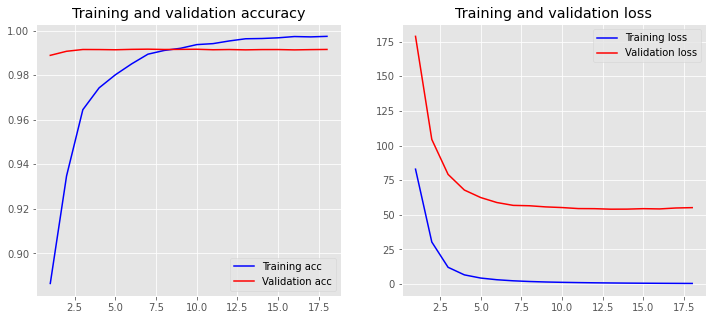

32/32 [==============================] - 10s 213ms/step
F1-score: 69.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7913899702312801,0.6857142857142857,0.7347719783140214,5040.0
Disease,0.6412129260734838,0.6526244649695877,0.646868371106397,4439.0
micro avg,0.7150253235790659,0.6702183774659775,0.6918971901546505,9479.0
macro avg,0.716301448152382,0.6691693753419368,0.6908201747102092,9479.0
weighted avg,0.7210623091893498,0.6702183774659775,0.6936068646528077,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 11002 words (7778 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 651, 100)          1878100   
                                                                 
 bidirectional_16 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,039,930
Trainable params: 2,039,930
Non-trainable

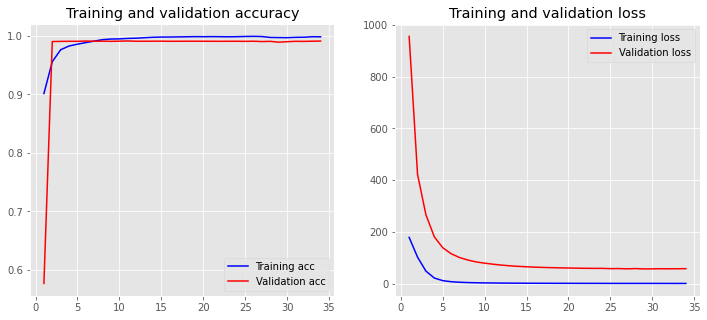

32/32 [==============================] - 10s 213ms/step
F1-score: 65.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7290362953692116,0.6934523809523809,0.7107992678462477,5040.0
Disease,0.5447733918128655,0.6715476458661861,0.6015538290788014,4439.0
micro avg,0.6308201831287746,0.6831944297921722,0.6559635350721702,9479.0
macro avg,0.6369048435910385,0.6825000134092836,0.6561765484625246,9479.0
weighted avg,0.6427462828271059,0.6831944297921722,0.6596398098138926,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10976 words (7770 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 651, 100)          1874700   
                                                                 
 bidirectional_17 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,036,530
Trainable params: 2,036,530
Non-trainable

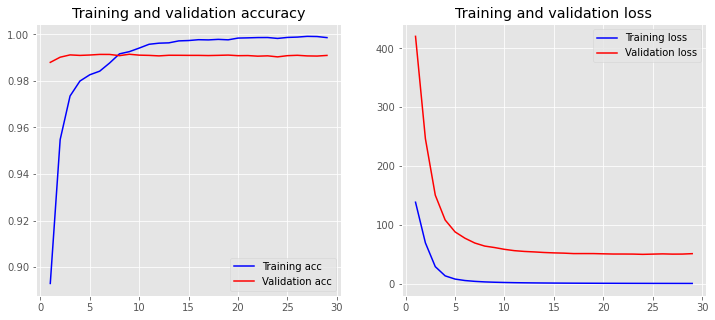

32/32 [==============================] - 11s 215ms/step
F1-score: 67.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6895761741122566,0.7166666666666667,0.7028604786923526,5040.0
Disease,0.6329170383586084,0.6393331831493579,0.6361089319735516,4439.0
micro avg,0.6634437358568196,0.6804515244224074,0.6718400083328994,9479.0
macro avg,0.6612466062354325,0.6779999249080123,0.669484705332952,9479.0
weighted avg,0.6630427946829449,0.6804515244224074,0.6716008399240481,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10989 words (7771 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 651, 100)          1876100   
                                                                 
 bidirectional_18 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,037,930
Trainable params: 2,037,930
Non-trainable

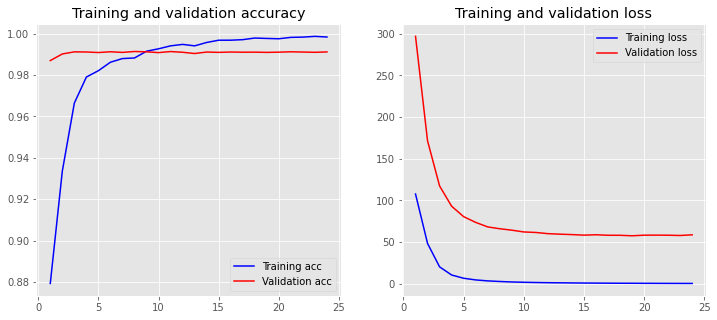

32/32 [==============================] - 10s 214ms/step
F1-score: 67.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.741272221032341,0.6867063492063492,0.7129467504377381,5040.0
Disease,0.6165141519472228,0.6526244649695877,0.6340555920332677,4439.0
micro avg,0.6786934244235696,0.6707458592678552,0.674696238128084,9479.0
macro avg,0.6788931864897819,0.6696654070879684,0.6735011712355029,9479.0
weighted avg,0.6828482239156789,0.6707458592678552,0.676002151623787,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10980 words (7757 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 651, 100)          1873800   
                                                                 
 bidirectional_19 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,035,630
Trainable params: 2,035,630
Non-trainable

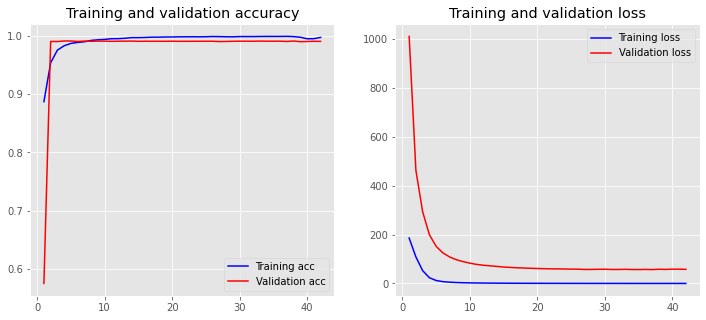

32/32 [==============================] - 10s 211ms/step
F1-score: 66.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7179274611398964,0.6873015873015873,0.7022807906741004,5040.0
Disease,0.602782392026578,0.6539761207479162,0.6273365748244192,4439.0
micro avg,0.6604086712996577,0.6716953265112353,0.6660041841004184,9479.0
macro avg,0.6603549265832371,0.6706388540247518,0.6648086827492599,9479.0
weighted avg,0.664005215988085,0.6716953265112353,0.6671845385212641,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 11007 words (7773 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 651, 100)          1878100   
                                                                 
 bidirectional_20 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,039,930
Trainable params: 2,039,930
Non-trainable

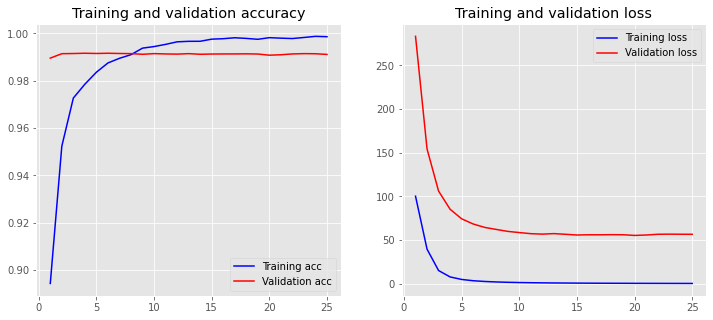

32/32 [==============================] - 10s 216ms/step
F1-score: 67.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6896162528216704,0.7273809523809524,0.7079953650057936,5040.0
Disease,0.6434802057705211,0.6481189457084929,0.6457912457912458,4439.0
micro avg,0.6685398998671708,0.6902626859373352,0.6792276549361569,9479.0
macro avg,0.6665482292960958,0.6877499490447226,0.6768933053985198,9479.0
weighted avg,0.6680108184024224,0.6902626859373352,0.6788652790058592,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 11024 words (7821 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 651, 100)          1884600   
                                                                 
 bidirectional_21 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,046,430
Trainable params: 2,046,430
Non-trainable

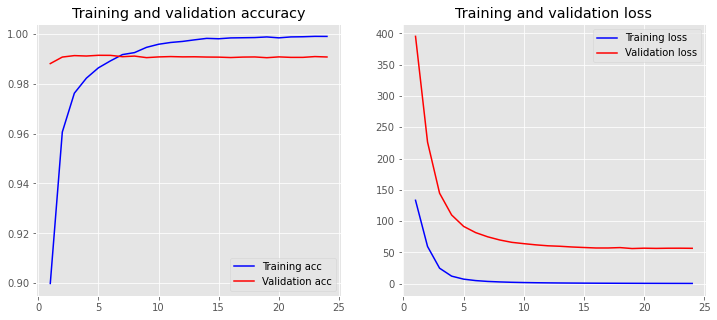

32/32 [==============================] - 10s 218ms/step
F1-score: 66.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7174775527249948,0.6817460317460318,0.6991555600773222,5040.0
Disease,0.5961656128900673,0.658481640009011,0.6257760650824233,4439.0
micro avg,0.6561081304168386,0.6708513556282308,0.6633978404882374,9479.0
macro avg,0.656821582807531,0.6701138358775214,0.6624658125798728,9479.0
weighted avg,0.6606673722283978,0.6708513556282308,0.6647920641091445,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 11012 words (7784 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 651, 100)          1879700   
                                                                 
 bidirectional_22 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,041,530
Trainable params: 2,041,530
Non-trainable

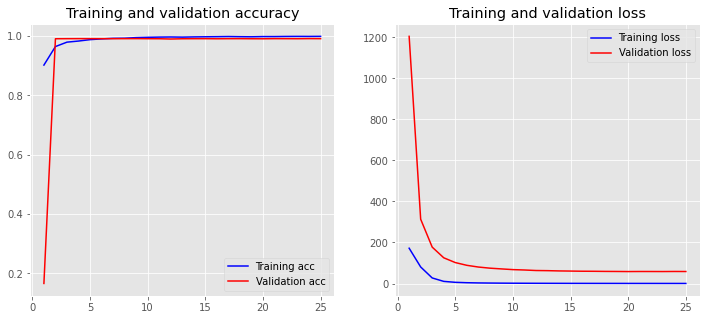

32/32 [==============================] - 10s 212ms/step
F1-score: 67.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7586282699494394,0.6847222222222222,0.719783084784649,5040.0
Disease,0.6179991449337323,0.6512728091912593,0.6341998464407151,4439.0
micro avg,0.6873306600195079,0.6690579175018462,0.6780712070993263,9479.0
macro avg,0.6883137074415859,0.6679975157067408,0.6769914656126821,9479.0
weighted avg,0.6927718836275991,0.6690579175018462,0.6797045960190913,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 11000 words (7796 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 651, 100)          1879700   
                                                                 
 bidirectional_23 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,041,530
Trainable params: 2,041,530
Non-trainable

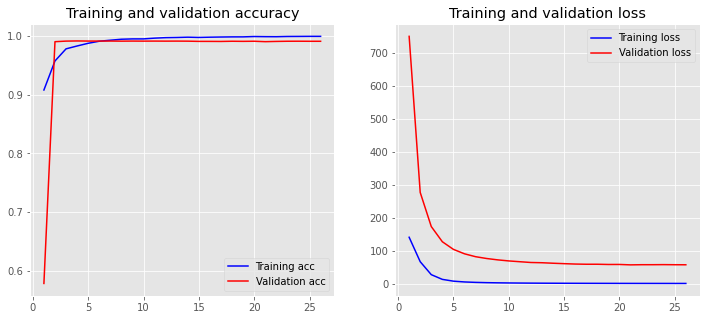

32/32 [==============================] - 10s 211ms/step
F1-score: 67.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6723823422108719,0.7313492063492063,0.7006272571754418,5040.0
Disease,0.6268849633778544,0.6555530524892994,0.6408985794516022,4439.0
micro avg,0.651521137890162,0.6958539930372403,0.6729582206805081,9479.0
macro avg,0.6496336527943631,0.6934511294192529,0.670762918313522,9479.0
weighted avg,0.6510759950603534,0.6958539930372403,0.6726564163255502,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 11034 words (7798 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 651, 100)          1883300   
                                                                 
 bidirectional_24 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,045,130
Trainable params: 2,045,130
Non-trainable

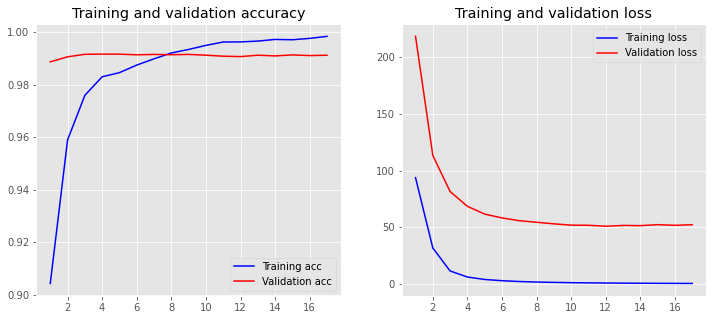

32/32 [==============================] - 10s 214ms/step
F1-score: 68.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6995165489029379,0.7464285714285714,0.7222115569207143,5040.0
Disease,0.6107859531772575,0.6582563640459563,0.6336333080342622,4439.0
micro avg,0.6577445384766778,0.7051376727502902,0.6806170765235987,9479.0
macro avg,0.6551512510400976,0.7023424677372638,0.6779224324774882,9479.0
weighted avg,0.6579641578884536,0.7051376727502902,0.6807305096787097,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 11020 words (7791 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 651, 100)          1881200   
                                                                 
 bidirectional_25 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,043,030
Trainable params: 2,043,030
Non-trainable

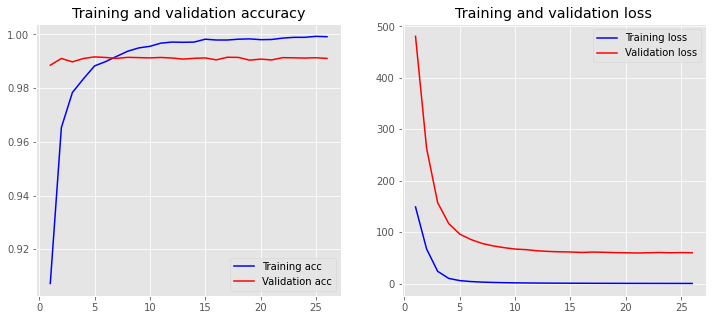

32/32 [==============================] - 10s 215ms/step
F1-score: 67.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.739306709912832,0.7236111111111111,0.7313747117216485,5040.0
Disease,0.575687185443283,0.6699707141248029,0.6192608016657992,4439.0
micro avg,0.6556094662837905,0.6984914020466294,0.6763714373276126,9479.0
macro avg,0.6574969476780574,0.696790912617957,0.6753177566937238,9479.0
weighted avg,0.662683957605592,0.6984914020466294,0.6788719533359627,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 11058 words (7807 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 651, 100)          1886600   
                                                                 
 bidirectional_26 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,048,430
Trainable params: 2,048,430
Non-trainable

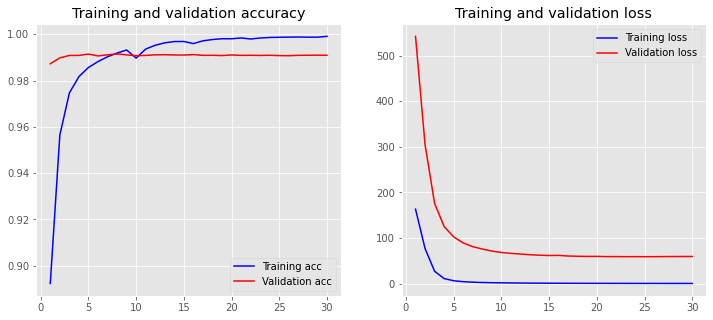

32/32 [==============================] - 10s 219ms/step
F1-score: 67.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7291622926726853,0.6890873015873016,0.7085586045088239,5040.0
Disease,0.6163644214162349,0.6431628745212886,0.6294785580421123,4439.0
micro avg,0.6735497605109101,0.6675809684565882,0.6705520822295221,9479.0
macro avg,0.6727633570444601,0.666125088054295,0.6690185812754681,9479.0
weighted avg,0.6763392363895981,0.6675809684565882,0.671525549728179,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10994 words (7786 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 651, 100)          1878100   
                                                                 
 bidirectional_27 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,039,930
Trainable params: 2,039,930
Non-trainable

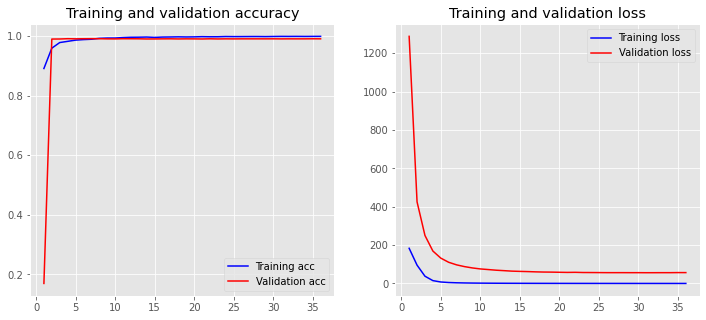

32/32 [==============================] - 10s 214ms/step
F1-score: 67.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.736346516007533,0.6982142857142857,0.7167736021998167,5040.0
Disease,0.6380648105887723,0.6298715927010587,0.6339417299625892,4439.0
micro avg,0.6893352254120729,0.6662095157717058,0.6775751072961372,9479.0
macro avg,0.6872056632981527,0.6640429392076722,0.675357666081203,9479.0
weighted avg,0.6903213561432141,0.6662095157717058,0.6779835736249614,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 11039 words (7798 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 651, 100)          1883800   
                                                                 
 bidirectional_28 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,045,630
Trainable params: 2,045,630
Non-trainable

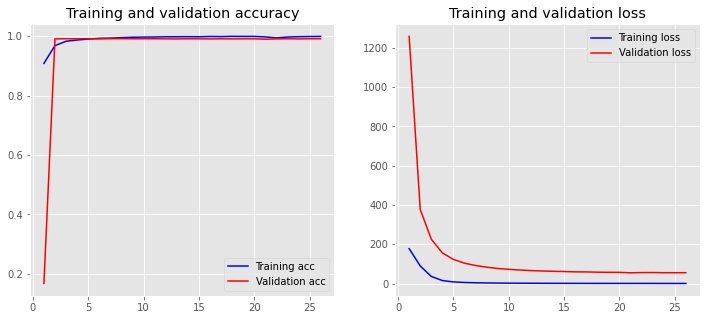

32/32 [==============================] - 10s 220ms/step
F1-score: 67.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.608259587020649,0.8182539682539682,0.6978003384094754,5040.0
Disease,0.6080146460537021,0.673349853570624,0.6390165686798502,4439.0
micro avg,0.608156634746922,0.7503956113514084,0.6718299881936245,9479.0
macro avg,0.6081371165371756,0.7458019109122962,0.6684084535446628,9479.0
weighted avg,0.6081448815715218,0.7503956113514084,0.6702719964082299,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 11040 words (7809 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 651, 100)          1885000   
                                                                 
 bidirectional_29 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,046,830
Trainable params: 2,046,830
Non-trainable

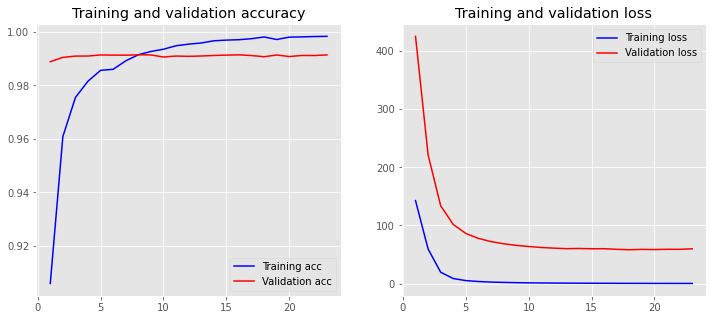

32/32 [==============================] - 10s 215ms/step
F1-score: 67.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7413394919168591,0.700595238095238,0.720391716821381,5040.0
Disease,0.6076714613299979,0.6566794323045732,0.6312256388046774,4439.0
micro avg,0.6742677824267782,0.6800295389809051,0.6771364042229108,9479.0
macro avg,0.6745054766234285,0.6786373351999055,0.6758086778130292,9479.0
weighted avg,0.6787429745864364,0.6800295389809051,0.6786353901712969,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11035 words (7820 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 651, 100)          1885600   
                                                                 
 bidirectional_30 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,047,430
Trainable params: 2,047,430
Non-trainab

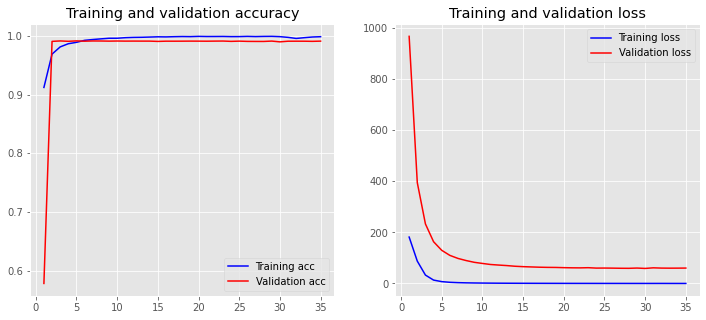

32/32 [==============================] - 10s 216ms/step
F1-score: 65.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6708813685384901,0.7158730158730159,0.692647341140334,5040.0
Disease,0.5920163766632549,0.6514980851543141,0.6203346203346204,4439.0
micro avg,0.6333430770729807,0.6857263424411858,0.6584945800830717,9479.0
macro avg,0.6314488726008725,0.683685550513665,0.6564909807374772,9479.0
weighted avg,0.6339490234668402,0.6857263424411858,0.6587834137580613,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11041 words (7830 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 651, 100)          1887200   
                                                                 
 bidirectional_31 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,049,030
Trainable params: 2,049,030
Non-trainab

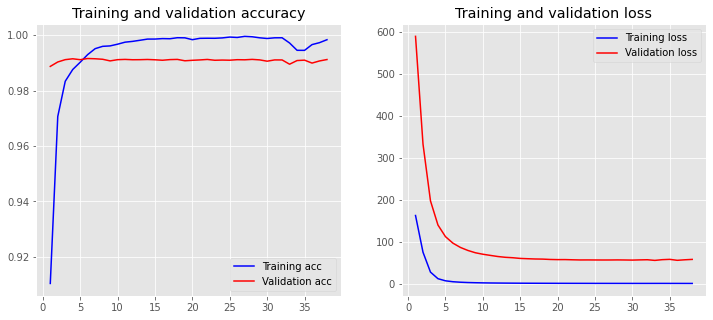

32/32 [==============================] - 10s 211ms/step
F1-score: 65.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6853456576160216,0.7061507936507937,0.6955926903156455,5040.0
Disease,0.5606805293005671,0.668168506420365,0.6097235070408058,4439.0
micro avg,0.6224363254793475,0.6883637514505749,0.6537421100090172,9479.0
macro avg,0.6230130934582944,0.6871596500355793,0.6526580986782257,9479.0
weighted avg,0.6269651845078559,0.6883637514505749,0.655380294012553,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11053 words (7828 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 651, 100)          1888200   
                                                                 
 bidirectional_32 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,050,030
Trainable params: 2,050,030
Non-trainab

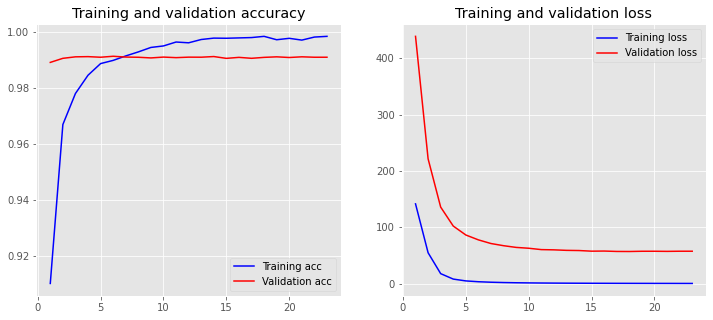

32/32 [==============================] - 10s 216ms/step
F1-score: 68.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7331004725703719,0.707936507936508,0.7202987786413647,5040.0
Disease,0.65415297982168,0.6280693849966209,0.6408458797839329,4439.0
micro avg,0.6962427429072188,0.6705348665471041,0.6831470335339639,9479.0
macro avg,0.6936267261960259,0.6680029464665644,0.6805723292126489,9479.0
weighted avg,0.6961294924763278,0.6705348665471041,0.6830911177036985,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11066 words (7835 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 651, 100)          1890200   
                                                                 
 bidirectional_33 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,052,030
Trainable params: 2,052,030
Non-trainab

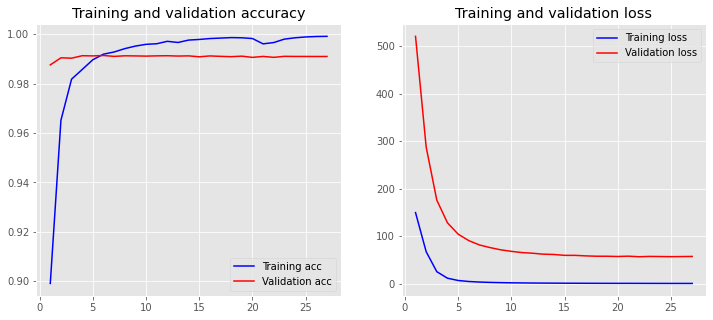

32/32 [==============================] - 10s 212ms/step
F1-score: 67.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7630994671403197,0.6819444444444445,0.7202430846605197,5040.0
Disease,0.6089783931193623,0.6539761207479162,0.630675646317619,4439.0
micro avg,0.6838528745550642,0.6688469247810951,0.6762666666666666,9479.0
macro avg,0.6860389301298411,0.6679602825961803,0.6754593654890693,9479.0
weighted avg,0.6909248234459395,0.6688469247810951,0.6782988016344477,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11060 words (7843 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 651, 100)          1890400   
                                                                 
 bidirectional_34 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,052,230
Trainable params: 2,052,230
Non-trainab

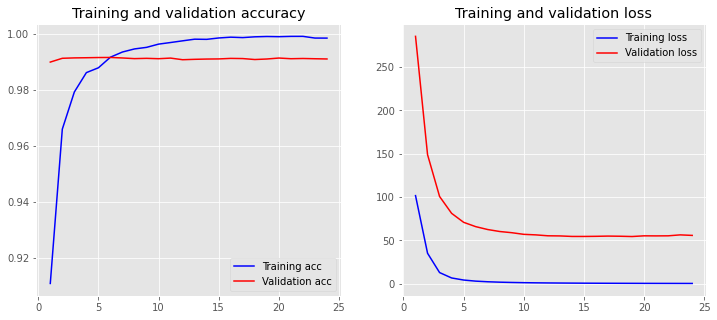

32/32 [==============================] - 10s 216ms/step
F1-score: 68.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7115120611884683,0.7198412698412698,0.7156524312062332,5040.0
Disease,0.6543715846994536,0.6474431178193287,0.6508889140527687,4439.0
micro avg,0.6850700663786745,0.6859373351619369,0.6855034264628359,9479.0
macro avg,0.682941822943961,0.6836421938302992,0.683270672629501,9479.0
weighted avg,0.6847532706900258,0.6859373351619369,0.6853237833906167,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11056 words (7857 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 651, 100)          1891400   
                                                                 
 bidirectional_35 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,053,230
Trainable params: 2,053,230
Non-trainab

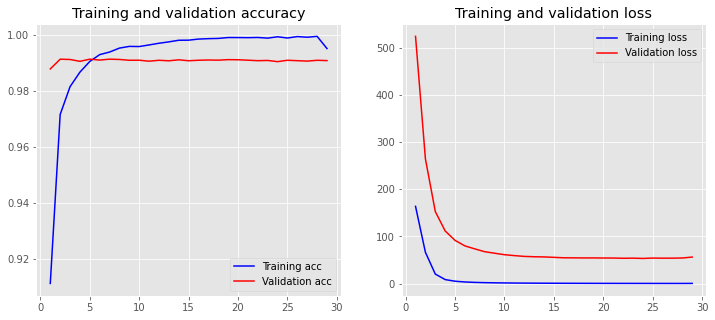

32/32 [==============================] - 10s 212ms/step
F1-score: 68.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7215214820654317,0.7263888888888889,0.7239470041526597,5040.0
Disease,0.6151877133105802,0.6496958774498761,0.6319710748329134,4439.0
micro avg,0.6704568735914772,0.6904736786580863,0.6803180707863417,9479.0
macro avg,0.6683545976880059,0.6880423831693825,0.6779590394927866,9479.0
weighted avg,0.6717255542773964,0.6904736786580863,0.6808748287912973,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11069 words (7845 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 651, 100)          1891500   
                                                                 
 bidirectional_36 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,053,330
Trainable params: 2,053,330
Non-trainab

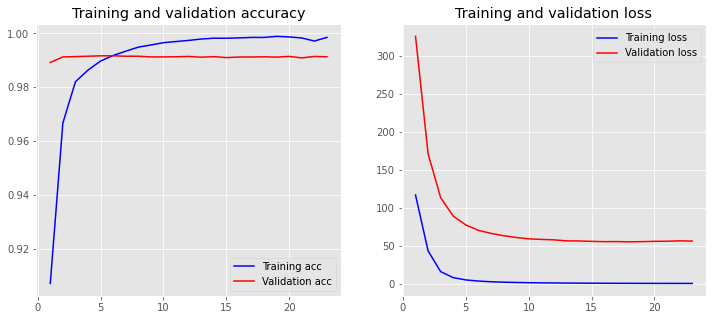

32/32 [==============================] - 10s 210ms/step
F1-score: 69.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7364919354838709,0.7248015873015873,0.7306,5040.0
Disease,0.648014440433213,0.6469925658932192,0.6475030999887272,4439.0
micro avg,0.6947402044293015,0.6883637514505749,0.691537279423454,9479.0
macro avg,0.692253187958542,0.6858970765974033,0.6890515499943637,9479.0
weighted avg,0.6950580710962909,0.6883637514505749,0.691685859357523,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11049 words (7833 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 651, 100)          1888300   
                                                                 
 bidirectional_37 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,050,130
Trainable params: 2,050,130
Non-trainab

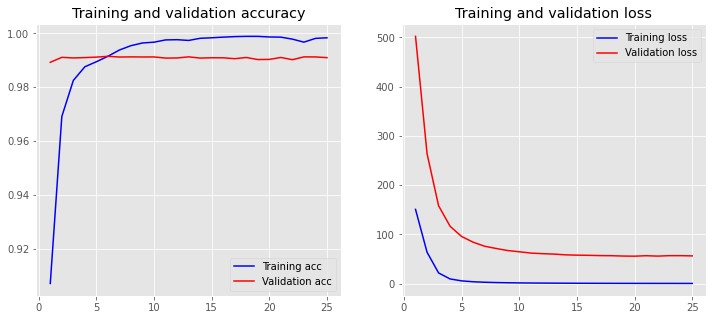

32/32 [==============================] - 10s 212ms/step
F1-score: 68.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7280736884261113,0.7214285714285714,0.7247358979469802,5040.0
Disease,0.61090303786933,0.6614102275287227,0.6351541373715522,4439.0
micro avg,0.6706122448979592,0.6933220803882266,0.6817781005238861,9479.0
macro avg,0.6694883631477206,0.6914193994786471,0.6799450176592663,9479.0
weighted avg,0.6732028668392823,0.6933220803882266,0.6827849078431375,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11052 words (7831 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 651, 100)          1888400   
                                                                 
 bidirectional_38 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,050,230
Trainable params: 2,050,230
Non-trainab

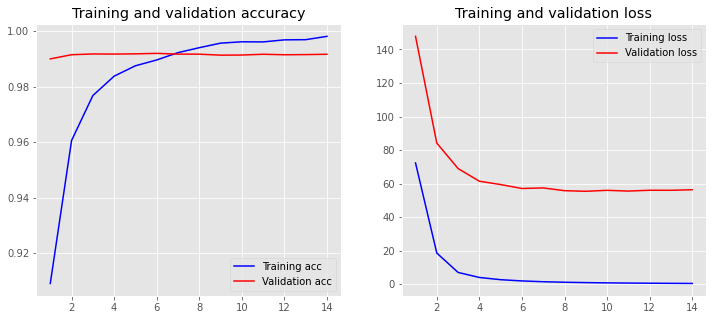

32/32 [==============================] - 10s 218ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.789839944328462,0.6755952380952381,0.7282643567532885,5040.0
Disease,0.6476039783001808,0.645415634151836,0.6465079544172402,4439.0
micro avg,0.7178019461934745,0.6614621795548054,0.6884813879433402,9479.0
macro avg,0.7187219613143214,0.6605054361235371,0.6873861555852643,9479.0
weighted avg,0.7232310770218326,0.6614621795548054,0.6899779689518623,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 11026 words (7804 misses)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 651, 100)          1883100   
                                                                 
 bidirectional_39 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_39 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,044,930
Trainable params: 2,044,930
Non-trainab

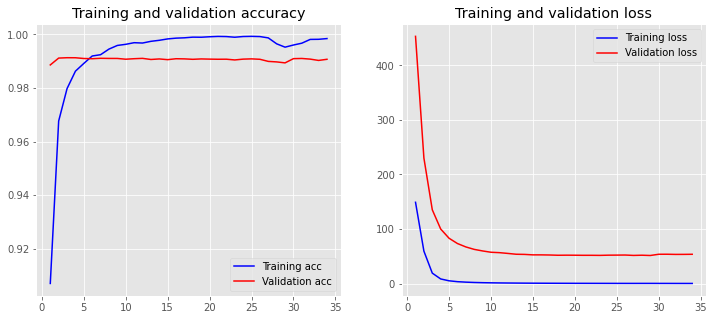

32/32 [==============================] - 10s 218ms/step
F1-score: 66.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6561028612821441,0.7188492063492063,0.6860443097898125,5040.0
Disease,0.6101871101871101,0.6611849515656679,0.6346632068331711,4439.0
micro avg,0.6347270615563299,0.6918451313429687,0.6620564332946344,9479.0
macro avg,0.6331449857346272,0.6900170789574371,0.6603537583114918,9479.0
weighted avg,0.6346005910942704,0.6918451313429687,0.6619826243773712,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11174 words (7926 misses)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 651, 100)          1910100   
                                                                 
 bidirectional_40 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,071,930
Trainable params: 2,071,930
Non-trainab

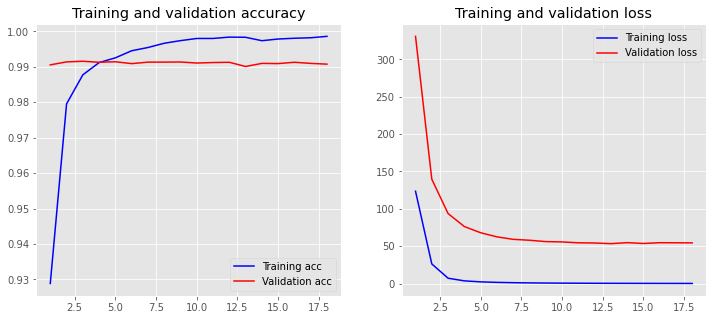

32/32 [==============================] - 10s 215ms/step
F1-score: 67.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7388468013468014,0.6966269841269841,0.7171160130718953,5040.0
Disease,0.6137320977253581,0.6564541563415184,0.6343746598454338,4439.0
micro avg,0.6763157894736842,0.6778141154130183,0.6770641235049266,9479.0
macro avg,0.6762894495360797,0.6765405702342513,0.6757453364586645,9479.0
weighted avg,0.6802557928674696,0.6778141154130183,0.6783683743998558,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11206 words (7919 misses)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 651, 100)          1912600   
                                                                 
 bidirectional_41 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_41 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_41 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,074,430
Trainable params: 2,074,430
Non-trainab

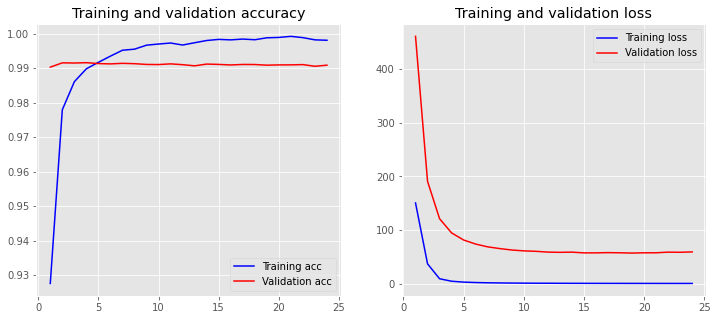

32/32 [==============================] - 10s 215ms/step
F1-score: 68.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7331123083298798,0.7019841269841269,0.7172106223393473,5040.0
Disease,0.6342369916921732,0.6535255688218067,0.643736824586708,4439.0
micro avg,0.685,0.6792910644582761,0.6821335875840882,9479.0
macro avg,0.6836746500110265,0.6777548479029668,0.6804737234630276,9479.0
weighted avg,0.6868091613149225,0.6792910644582761,0.6828029645459128,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11146 words (7920 misses)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 651, 100)          1906700   
                                                                 
 bidirectional_42 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_42 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_42 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,068,530
Trainable params: 2,068,530
Non-trainab

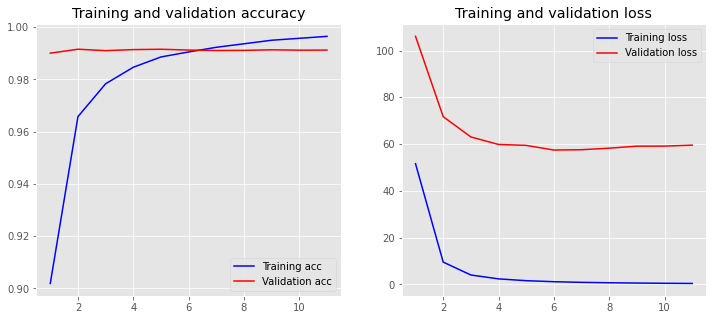

32/32 [==============================] - 10s 211ms/step
F1-score: 69.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7627916934275316,0.7069444444444445,0.7338070229636494,5040.0
Disease,0.6499776486365668,0.6551025005631899,0.6525300123415235,4439.0
micro avg,0.7075997813012576,0.6826669479902944,0.694909793814433,9479.0
macro avg,0.7063846710320492,0.6810234725038171,0.6931685176525865,9479.0
weighted avg,0.7099610631050194,0.6826669479902944,0.6957451335078401,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11135 words (7912 misses)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 651, 100)          1904800   
                                                                 
 bidirectional_43 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_43 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_43 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,066,630
Trainable params: 2,066,630
Non-trainab

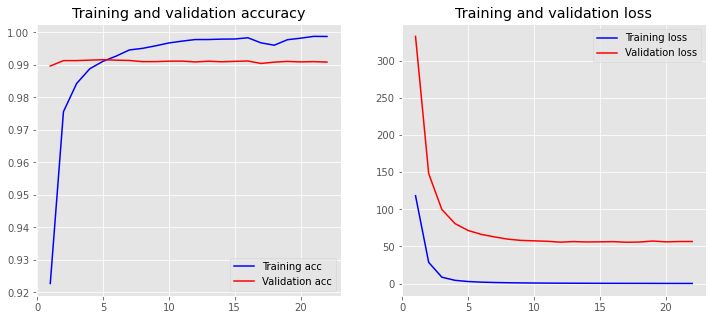

32/32 [==============================] - 10s 213ms/step
F1-score: 66.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8045862412761715,0.6404761904761904,0.7132125497127706,5040.0
Disease,0.5946229783658895,0.6377562514079748,0.6154347826086957,4439.0
micro avg,0.6906417417075117,0.6392024475155608,0.6639272408503178,9479.0
macro avg,0.6996046098210305,0.6391162209420826,0.6643236661607331,9479.0
weighted avg,0.7062607930159392,0.6392024475155608,0.6674233833265496,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11178 words (7946 misses)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 651, 100)          1912500   
                                                                 
 bidirectional_44 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_44 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_44 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,074,330
Trainable params: 2,074,330
Non-trainab

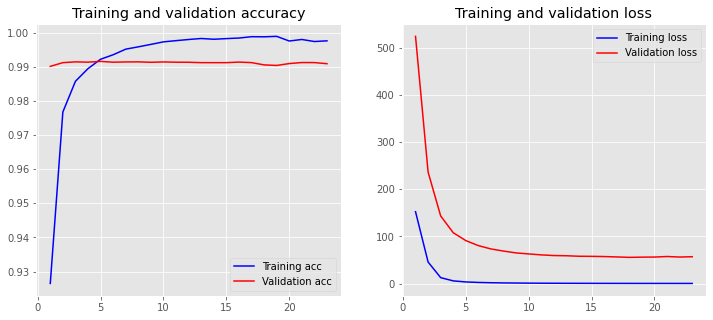

32/32 [==============================] - 10s 214ms/step
F1-score: 66.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6665443873807777,0.721031746031746,0.6927182615325962,5040.0
Disease,0.6341571050308914,0.6474431178193287,0.6407312451231747,4439.0
micro avg,0.6518429487179487,0.6865703133241903,0.6687561013204542,9479.0
macro avg,0.6503507462058346,0.6842374319255373,0.6667247533278855,9479.0
weighted avg,0.6513774766991504,0.6865703133241903,0.668372827853788,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11232 words (7929 misses)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 651, 100)          1916200   
                                                                 
 bidirectional_45 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_45 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_45 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,078,030
Trainable params: 2,078,030
Non-trainab

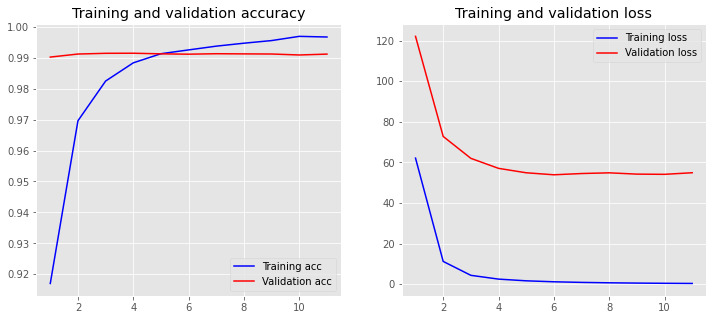

32/32 [==============================] - 10s 219ms/step
F1-score: 69.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.797700070406008,0.674404761904762,0.730889151704118,5040.0
Disease,0.6574830726126547,0.6343771119621536,0.6457234579224949,4439.0
micro avg,0.7274110486891385,0.6556598797341492,0.6896743050546524,9479.0
macro avg,0.7275915715093313,0.6543909369334577,0.6883063048133065,9479.0
weighted avg,0.7320366825797927,0.6556598797341492,0.6910061983655142,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11149 words (7911 misses)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 651, 100)          1906100   
                                                                 
 bidirectional_46 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_46 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_46 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,067,930
Trainable params: 2,067,930
Non-trainab

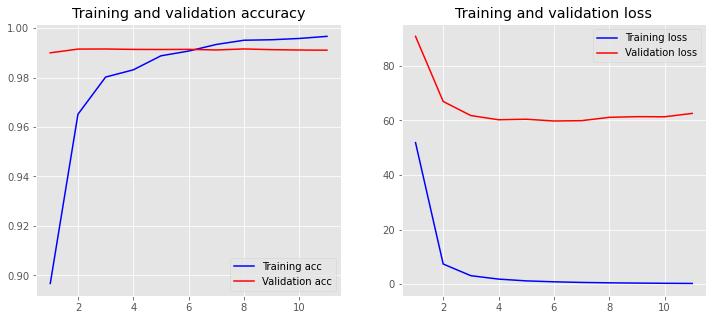

32/32 [==============================] - 10s 211ms/step
F1-score: 69.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8516497791634191,0.6503968253968254,0.7375407807402408,5040.0
Disease,0.6724870221802737,0.6420364947060149,0.6569090699550536,4439.0
micro avg,0.7577593668851242,0.6464816963814748,0.6977114881020153,9479.0
macro avg,0.7620684006718463,0.6462166600514201,0.6972249253476472,9479.0
weighted avg,0.7677481568142069,0.6464816963814748,0.6997810841292643,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11174 words (7936 misses)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 651, 100)          1911100   
                                                                 
 bidirectional_47 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_47 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_47 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,072,930
Trainable params: 2,072,930
Non-trainab

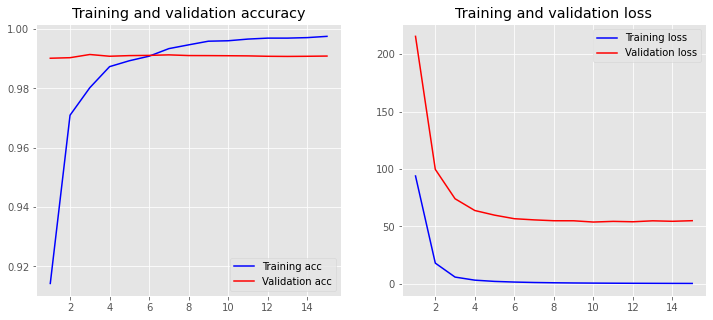

32/32 [==============================] - 10s 212ms/step
F1-score: 67.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7621095518334088,0.6680555555555555,0.7119898498625502,5040.0
Disease,0.6455956184390689,0.6373056994818653,0.641423874844122,4439.0
micro avg,0.7040909090909091,0.6536554488870134,0.677936429782811,9479.0
macro avg,0.7038525851362388,0.6526806275187105,0.6767068623533361,9479.0
weighted avg,0.7075462698060352,0.6536554488870134,0.6789439206393407,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11162 words (7912 misses)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 651, 100)          1907500   
                                                                 
 bidirectional_48 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_48 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_48 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,069,330
Trainable params: 2,069,330
Non-trainab

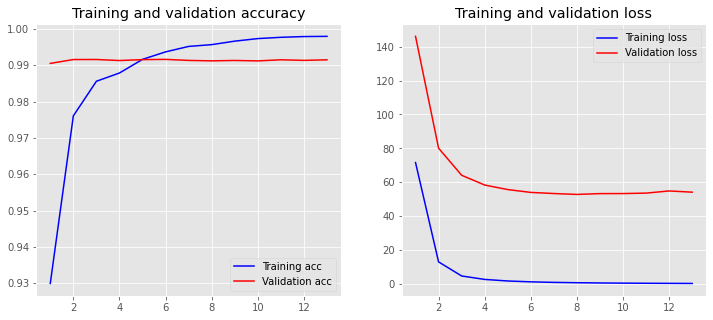

32/32 [==============================] - 10s 204ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7929816297691945,0.6680555555555555,0.725177686840405,5040.0
Disease,0.6656398104265403,0.6328001802207704,0.6488047118604919,4439.0
micro avg,0.7295062603354595,0.6515455216795021,0.6883254388409028,9479.0
macro avg,0.7293107200978675,0.650427867888163,0.6869911993504485,9479.0
weighted avg,0.7333476666863754,0.6515455216795021,0.6894123491533247,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11169 words (7935 misses)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 651, 100)          1910500   
                                                                 
 bidirectional_49 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_49 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_49 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,072,330
Trainable params: 2,072,330
Non-trainab

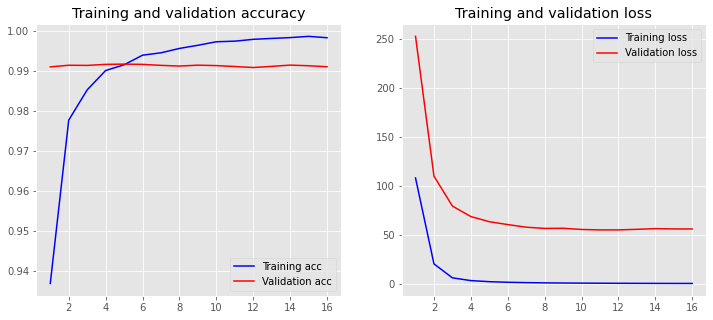

32/32 [==============================] - 9s 203ms/step
F1-score: 69.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6942039894617991,0.7319444444444444,0.7125748502994013,5040.0
Disease,0.6817209412883289,0.6460914620410002,0.6634281748785564,4439.0
micro avg,0.6886881630080874,0.691739634982593,0.6902105263157895,9479.0
macro avg,0.687962465375064,0.6890179532427223,0.6880015125889789,9479.0
weighted avg,0.6883581986777465,0.691739634982593,0.6895595436011072,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11464 words (8151 misses)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 651, 100)          1961600   
                                                                 
 bidirectional_50 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_50 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_50 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,123,430
Trainable params: 2,123,430
Non-trainab

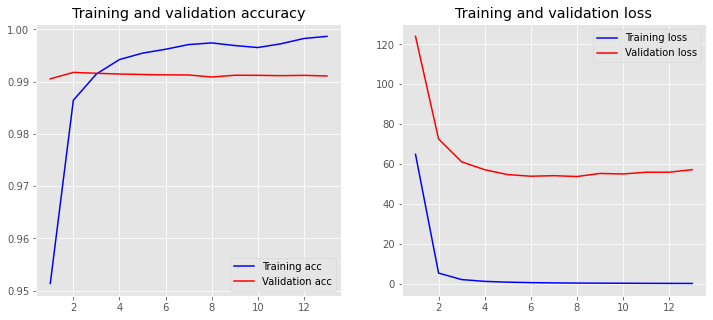

32/32 [==============================] - 10s 218ms/step
F1-score: 67.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7279144385026738,0.6751984126984127,0.7005661348430262,5040.0
Disease,0.6536518144235186,0.6411353908537959,0.647333105879677,4439.0
micro avg,0.6921032229482778,0.6592467559869184,0.6752755565161012,9479.0
macro avg,0.6907831264630961,0.6581669017761043,0.6739496203613515,9479.0
weighted avg,0.6931373746470594,0.6592467559869184,0.6756371955489755,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11504 words (8147 misses)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 651, 100)          1965200   
                                                                 
 bidirectional_51 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_51 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_51 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,127,030
Trainable params: 2,127,030
Non-trainab

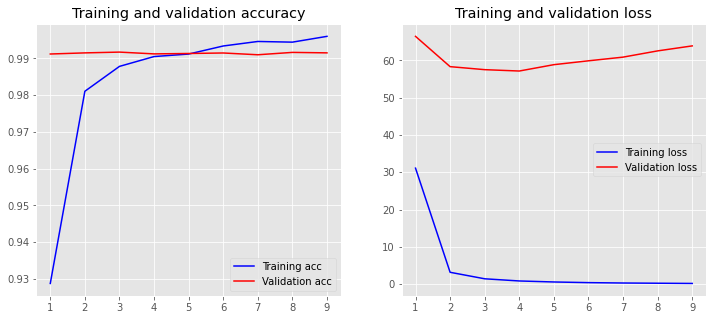

32/32 [==============================] - 10s 215ms/step
F1-score: 68.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8386346004654771,0.643452380952381,0.7281913102054565,5040.0
Disease,0.6435487502814682,0.6438387024104528,0.6436936936936937,4439.0
micro avg,0.7343524313914299,0.6436332946513346,0.6860066340585821,9479.0
macro avg,0.7410916753734726,0.6436455416814169,0.6859425019495751,9479.0
weighted avg,0.7472762199436062,0.6436332946513346,0.6886212163457966,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11473 words (8123 misses)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 651, 100)          1959700   
                                                                 
 bidirectional_52 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_52 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_52 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,121,530
Trainable params: 2,121,530
Non-trainab

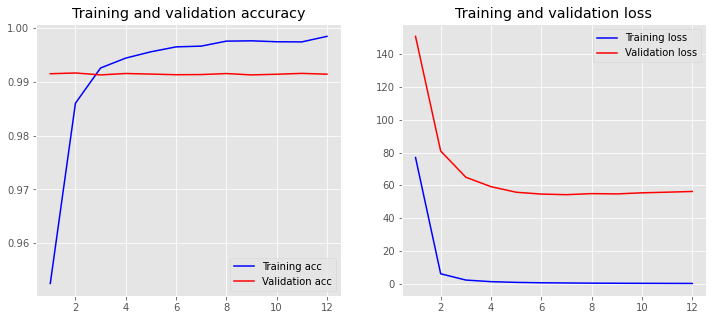

32/32 [==============================] - 10s 214ms/step
F1-score: 69.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7985257985257985,0.6448412698412699,0.7135016465422613,5040.0
Disease,0.7009252313078269,0.631448524442442,0.6643754444181086,4439.0
micro avg,0.7501549138678895,0.6385694693533073,0.6898791885115112,9479.0
macro avg,0.7497255149168127,0.638144897141856,0.688938545480185,9479.0
weighted avg,0.7528196145527448,0.6385694693533073,0.6904959274548983,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11463 words (8150 misses)
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, 651, 100)          1961400   
                                                                 
 bidirectional_53 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_53 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_53 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,123,230
Trainable params: 2,123,230
Non-trainab

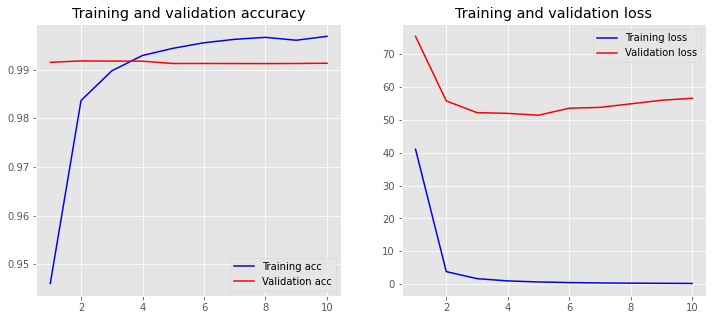

32/32 [==============================] - 10s 207ms/step
F1-score: 69.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7792238523426408,0.6533730158730159,0.710770559033024,5040.0
Disease,0.7200311364815776,0.6251407974769092,0.669239117327867,4439.0
micro avg,0.750990099009901,0.6401519147589408,0.6911555327752149,9479.0
macro avg,0.7496274944121092,0.6392569066749625,0.6900048381804456,9479.0
weighted avg,0.7515040015453774,0.6401519147589408,0.6913214536707292,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11491 words (8148 misses)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, 651, 100)          1964000   
                                                                 
 bidirectional_54 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_54 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_54 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,125,830
Trainable params: 2,125,830
Non-trainab

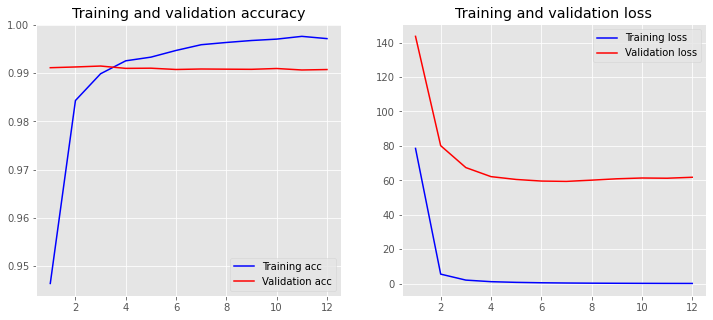

32/32 [==============================] - 10s 208ms/step
F1-score: 67.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7417188898836168,0.6575396825396825,0.6970971813209929,5040.0
Disease,0.6846915460776847,0.6075692723586393,0.6438290761518263,4439.0
micro avg,0.7149994052575235,0.6341386222175335,0.6721458123672146,9479.0
macro avg,0.7132052179806507,0.6325544774491609,0.6704631287364096,9479.0
weighted avg,0.7150130792332811,0.6341386222175335,0.6721518158978543,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11424 words (8128 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 651, 100)          1955300   
                                                                 
 bidirectional (Bidirectiona  (None, 651, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 651, 5)           1005      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 651, 5)            25        
                                                                 
Total params: 2,117,130
Trainable params: 2,117,130
Non-trainable 

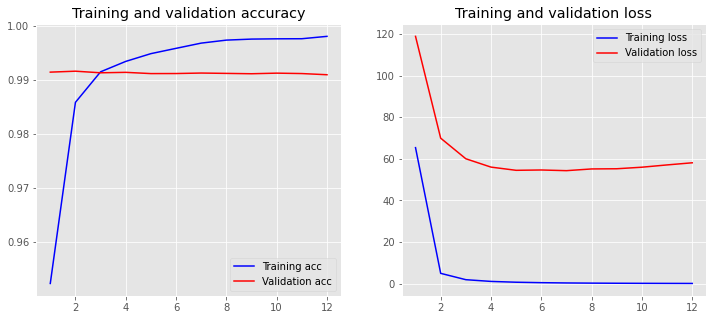

32/32 [==============================] - 10s 210ms/step
F1-score: 68.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8598183881952327,0.6011904761904762,0.7076132648295188,5040.0
Disease,0.6964102564102564,0.6118495156566794,0.651397050005996,4439.0
micro avg,0.7739762931034483,0.6061820867180082,0.6798793113648465,9479.0
macro avg,0.7781143223027446,0.6065199959235779,0.6795051574177574,9479.0
weighted avg,0.78329463073205,0.6061820867180082,0.6812873045381782,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11488 words (8095 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 651, 100)          1958400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,120,230
Trainable params: 2,120,230
Non-trainabl

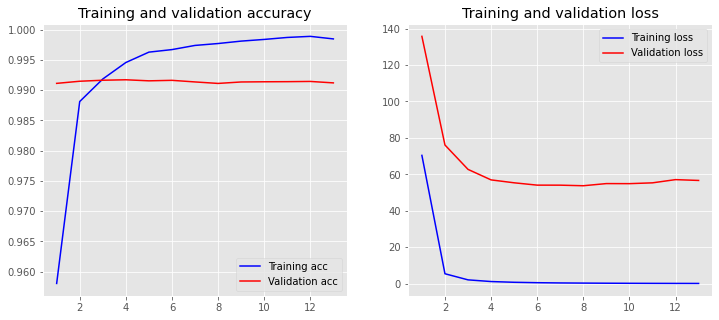

32/32 [==============================] - 10s 218ms/step
F1-score: 69.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7636605952909817,0.6821428571428572,0.7206036470341647,5040.0
Disease,0.69025,0.6219869339941428,0.65434293162697,4439.0
micro avg,0.7291225593977888,0.6539719379681401,0.6895055892330794,9479.0
macro avg,0.7269552976454909,0.6520648955685,0.6874732893305673,9479.0
weighted avg,0.7292825351056597,0.6539719379681401,0.6895738637561251,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11487 words (8130 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 651, 100)          1961800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,123,630
Trainable params: 2,123,630
Non-trainabl

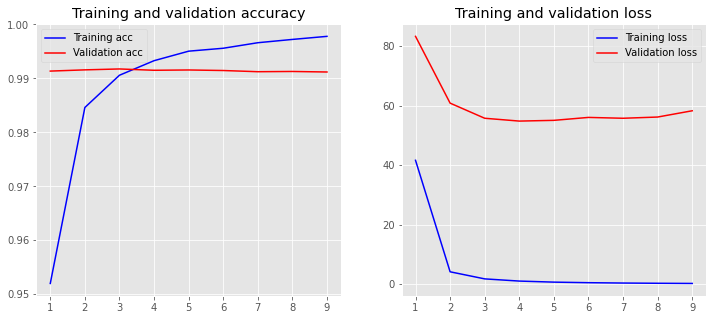

32/32 [==============================] - 10s 208ms/step
F1-score: 69.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.855564537860415,0.6299603174603174,0.7256313564164096,5040.0
Disease,0.6974874371859296,0.625366073439964,0.6594607435562418,4439.0
micro avg,0.7737615394617084,0.6278088405949994,0.6931857891671519,9479.0
macro avg,0.7765259875231723,0.6276631954501407,0.6925460499863257,9479.0
weighted avg,0.7815372934365263,0.6278088405949994,0.6946437680119065,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11473 words (8134 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 651, 100)          1960800   
                                                                 
 bidirectional_3 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,122,630
Trainable params: 2,122,630
Non-trainabl

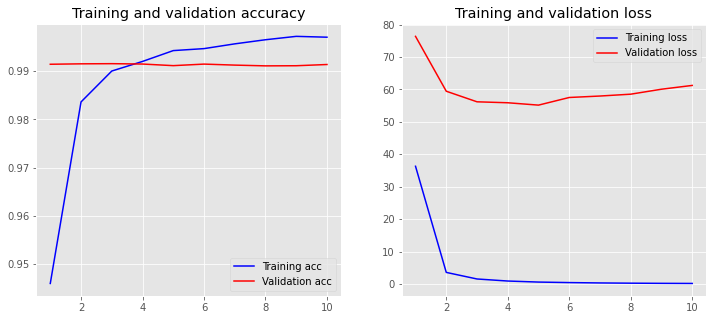

32/32 [==============================] - 10s 205ms/step
F1-score: 69.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7832183908045977,0.6759920634920635,0.7256656017039402,5040.0
Disease,0.6629646418857661,0.6589321919351205,0.660942266410575,4439.0
micro avg,0.7226660579776307,0.6680029538980905,0.6942601831039965,9479.0
macro avg,0.7230915163451819,0.667462127713592,0.6933039340572575,9479.0
weighted avg,0.7269037593613343,0.6680029538980905,0.6953557709868553,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11443 words (8141 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 651, 100)          1958500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,120,330
Trainable params: 2,120,330
Non-trainabl

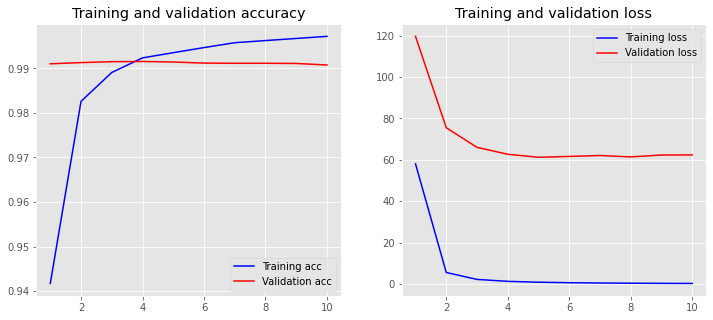

32/32 [==============================] - 10s 213ms/step
F1-score: 68.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8238315356959425,0.6365079365079365,0.7181553615401836,5040.0
Disease,0.6849178695868592,0.6199594503266501,0.650821804422372,4439.0
micro avg,0.7532861476238625,0.6287583078383796,0.6854119947099073,9479.0
macro avg,0.7543747026414008,0.6282336934172933,0.6844885829812778,9479.0
weighted avg,0.7587784959387719,0.6287583078383796,0.6866231682660021,9479.0



In [13]:
number_of_training_models = 5
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)